# 情緒分析

資料集: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015.pdf)

程式碼參考自: [huggingface](https://huggingface.co/)

> **資料集說明**

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

>**本次介紹模型為BERT**

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://github.com/google-research/bert)

程式碼參考自: [huggingface](https://huggingface.co/)

![](https://i.imgur.com/spiKPbQ.png)

[可搭配李宏毅大大的說明影片食用](https://youtu.be/UYPa347-DdE)

**訓練一個BERT分類模型，輸入是一句話，辨識出這句話的情緒傾向。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉。 **如 "HW2-BERT-111423048.ipynb"**

請 **隨意修改** 這個colab的程式來完成訓練BERT分類模型。**要跑得出來Testing Accuracy, 須完成TODO1-7**，不必一定要照著提示走。
繳交時記得改檔案標題的學號。

本次作業著重在學習pytorch的使用方法及Transformer家族中BERT的應用。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型可自行多嘗試不同組合，**不能只用已經pretrained好的模型**，一定再用新的資料訓練過
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

* 基本分（85分）：20 + （Test_Acc-85） + Training function（20分） + Model（15分） + 文件（15分）

* 加分項（15分）：請附上二至三種的pretrained模型結果（一個5分）**[Transformer 模型總覽](https://huggingface.co/docs/transformers/index)**

> 舉例：原本是bert-base-uncased（完成這個就已經有5分了），如果你換其他模型如 distilbert-base-uncased，再完成一次並記錄結果可以再加5分（可在文件中敘述不同模型的差異或建議）

1. 20分免費送
2. 用訓練完的bert-base-uncased模型去看Test資料的accuracy再減去85
3. 完成前置準備所需的程式碼(資料處理等)，共20分(包含TODO1-4)
4. 完成模型建構，模型訓練及模型預測，共15分 (TODO5-7)
5. 15分是文件分數
6. 加分項15分：最多只加到15分（即完成3個模型）

有問題再來信助教: joyce111423048@g.ncu.edu.tw

### 資料集下載

- 資料集說明 : 
  - text: a string feature.
  - label: a classification label, with possible values including neg (0), pos (1).

### 請注意
* TODO
> ```
> ##########
> # todo #
> ##########
> ```

## 安裝與載入所需套件

In [170]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [171]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as Fun
import torch.nn as nn
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


## 一些模型會用到的小函數

* TODO1: 完成get_pred()
> 從logits的dimension=1去取得結果中數值最高者當做預測結果
* TODO2: 完成cal_metrics()
> 透過將tensor轉為numpy，可使用sklearn的套件算出acc, f1_score, recall及precision

In [172]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

# get predict result
def get_pred(logits):
  
  '''
  Parameter
  ---------
  logits: torch.tensor, model outputs (batch_size, max_length, vocab_size)
  ---------
  ''' 

  logits = logits.argmax(dim=-1)
  return logits

# calculate confusion metrics
def cal_metrics(pred, ans, average):

  '''
  Parameter
  ---------
  pred: [list], predict sentences
  ans: [list], true sentence
  ---------
  ''' 
  
  # 將Tensor轉換為NumPy數組
  pred_numpy = pred.cpu().numpy()
  ans_numpy = ans.cpu().numpy()

  # 計算精度、F1分數、召回率和精確度等指標
  acc = accuracy_score(pred_numpy, ans_numpy)
  f1 = f1_score(pred_numpy, ans_numpy, average='macro')
  recall = recall_score(pred_numpy, ans_numpy, average='macro')
  precision = precision_score(pred_numpy, ans_numpy, average='macro')

  return acc, f1, recall, precision


In [173]:
# save model to path
def save_checkpoint(save_path, model):
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):    
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  
  model.load_state_dict(state_dict)
  return model

## 載入資料

這個資料集有分成train, test, unsupervised。

這次我們只使用train及test資料，且我們需要將原資料重新進行分割。

將兩份資料合併後切割成 3:1:1 或是 8:1:1 的 train/val/test 資料集。

In [174]:
from datasets import load_dataset

dataset = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

看一下資料格式長怎樣

In [175]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [176]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

* TODO3:把資料拿出來後，將train及test合併，重新切割後，儲存下來。

In [177]:
from sklearn.model_selection import train_test_split
from datasets import concatenate_datasets

dataset_train = load_dataset("imdb", split="train")
dataset_test = load_dataset("imdb", split="test")
dataset_un = load_dataset("imdb", split="unsupervised")

# 轉成dataframe
train_data = pd.DataFrame(dataset_train)
test_data = pd.DataFrame(dataset_test)

all_df = pd.concat([train_data, test_data])

all_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


可以看一下兩個類別分布的比例

In [178]:
all_df.label.value_counts() / len(all_df)

0    0.5
1    0.5
Name: label, dtype: float64

In [179]:
from sklearn.model_selection import train_test_split

train_df, temp_data = train_test_split(all_df, random_state=1111, train_size=0.8)
dev_df, test_df = train_test_split(temp_data, random_state=1111, train_size=0.5)
print('# of train_df:', len(train_df))
print('# of dev_df:', len(dev_df))
print('# of test_df data:', len(test_df))

# save data
train_df.to_csv('./train.tsv', sep='\t', index=False)
dev_df.to_csv('./val.tsv', sep='\t', index=False)
test_df.to_csv('./test.tsv', sep='\t', index=False)

# of train_df: 40000
# of dev_df: 5000
# of test_df data: 5000


### 自定義 Dataset，將tokenzie的步驟放進去

* TODO4: 完成tokenize()
> 我們會需要拿到該句話的 input_ids、attenntion_mask 及 token_type_ids。

In [180]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch
import torch.nn.functional as Fun

# Using Dataset to build DataLoader
class CustomDataset(Dataset):
  def __init__(self, mode, df, specify, args):
    assert mode in ["train", "val", "test"]  # 一般會切三份
    self.mode = mode
    self.df = df
    self.specify = specify # specify column of data (the column U use for predict)
    if self.mode != 'test':
      self.label = df['label']
    self.tokenizer = AutoTokenizer.from_pretrained(args["config"])
    self.max_len = args["max_len"]
    self.num_class = args["num_class"]
      
  def __len__(self):
    return len(self.df)

  # transform label to one_hot label (if num_class > 2)
  def one_hot_label(self, label):
    return Fun.one_hot(torch.tensor(label), num_classes = self.num_class)
  
  # transform text to its number
  def tokenize(self,input_text):
    
    encoded_dict = self.tokenizer.encode_plus(
            input_text, 
            add_special_tokens=True, # 添加 [CLS] 和 [SEP] 标记
            max_length = self.max_len, # 设定最大长度
            pad_to_max_length = True, # 使用 padding 填充长度
            return_attention_mask = True, # 返回 attention mask
            return_token_type_ids=True, # 返回 token type ids
            truncation=True, 
          )
    
    input_ids = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_ids = encoded_dict['token_type_ids']

    return input_ids, attention_mask, token_type_ids

  # get single data
  def __getitem__(self, index):
      
    sentence = str(self.df[self.specify][index])
    ids, mask, token_type_ids = self.tokenize(sentence)
    

    if self.mode == "test":
        return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long)
    else:
        if self.num_class > 2:
          return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long), self.one_hot_label(self.label[index])
        else:
          return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long), torch.tensor(self.label[index], dtype=torch.long)

## 建立模型

*   自己重新寫分類模型
*   模型訓練與評估的程式碼大致上相同，差別在於模型是否繼續進行梯度下降，以及模型參數是否繼續訓練



* TODO5: 完成BertClassifier
> 在初始化的地方加上dropout, linear layer（等於一層NN），其維度為類別數量；
> 在forward function中把輸入值放進對應層數（bert -> dropout -> classifier）；
> 請注意我們只取用bert輸出的sentence representation去做分類

In [181]:
# BERT Model
class BertClassifier(BertPreTrainedModel):
  def __init__(self, config, args):

    super(BertClassifier, self).__init__(config)
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(args["dropout"])
    self.classifier = nn.Linear(config.hidden_size, args["num_class"])
    self.init_weights()

  # forward function, data in model will do this
  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, 
              head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, 
              output_hidden_states=None, return_dict=None):
  
    outputs = self.bert(input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        head_mask=head_mask,
                        inputs_embeds=inputs_embeds,
                        output_attentions=output_attentions,
                        output_hidden_states=output_hidden_states,
                        return_dict=return_dict)
    
    pooled_output = outputs.pooler_output
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    return logits
    

這是已經寫好的evaluate()，train()會跟他很像

(# 在評估模型的時候，不需要梯度下降)

In [182]:
# evaluate dataloader
def evaluate(model, data_loader, device):
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  loss_fct = torch.nn.CrossEntropyLoss()
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      ids, masks, token_type_ids, labels = [t.to(device) for t in data]

      logits = model(input_ids = ids, 
              token_type_ids = token_type_ids, 
              attention_mask = masks)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
      loss = loss_fct(logits, labels)
      
      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count+=1

    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count
      
  return val_loss, val_acc, val_f1, val_rec, val_prec

## 開始訓練

### 定義你的 Hyperparameters

* 如果電腦的記憶體不夠可以試著減少 batch_size
* 因為我們採用現有的模型去fine-tune，所以一般不需要設太多 epochs
* config 就是我們所使用的現有模型，可以自己找適合的做替換
* 這份 work 是做二分類，所以 num_class 為 2
* 如果你的模型 overfit 了，可以把 dropout 調高
* 可以試著調高或調低 learning_rate，這會影響他的學習速度（跨步的大小）
* 你應該先檢閱你的資料再來決定 max_len （但 BERT 最大只吃到 512）

In [183]:
from datetime import datetime
parameters = {
    "num_class": 2,
    "time": str(datetime.now()).replace(" ", "_"),
    # Hyperparameters
    "model_name": 'BERT',
    "config": 'bert-base-uncased',
    "learning_rate": 1e-4,
    "epochs": 3,
    "max_len": 512,
    "batch_size": 16,
    "dropout": 0.1,
}

### 載入資料

讀入資料並傳入自訂的Dataset以自訂資料格式

之後傳入DataLoader以利後續訓練進行（將資料批次化以免記憶體爆掉）

(# 你可以決定要sample部分資料還是全部都丟進去)

In [184]:
import transformers
import pandas as pd

# load training data
train_df = pd.read_csv('./train.tsv', sep = '\t').sample(4000).reset_index(drop=True) 
train_dataset = CustomDataset('train', train_df, 'text', parameters)
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)

# load validation data
val_df = pd.read_csv('./val.tsv', sep = '\t').sample(500).reset_index(drop=True) 
val_dataset = CustomDataset('val', val_df, 'text', parameters)
val_loader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=True)

### 初始化模型
*   載入模型（這邊會使用已經訓練過的模型，Fine-tune我們的資料集）
*   定義Optimization
  *   通常用Adam就可以了，你也可以換SGD之類的試看看
  *   可以自己看需不需要加scheduler（可以自己寫一個function，也可以直接套用現有的function）
  
  ［請記得pytorch中是以step去計算，想要用epoch去訂定需自行換算］




In [185]:
transformers.logging.set_verbosity_error() # close the warning message

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
loss_fct = torch.nn.CrossEntropyLoss() # we use cross entrophy loss

## You can custom your optimizer (e.g. SGD .etc) ##
# we use Adam here
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

## You also can add your custom scheduler ##
# num_train_steps = len(train_loader) * parameters['epochs]
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_train_steps), num_training_steps=num_train_steps, num_cycles=1)

* 因為是做分類任務，所以這裡用CrossEntrophyLoss
* 由於在pytorch中，CrossEntrophyLoss吃的input是未經softmax的值，所以在模型中不必加入softmax
* 但若在後期想取得各類別實際機率就要經過softmax轉換
* logits的數值不等於機率 ！！但一般而言，logits中較大者會與經過softmax轉換後的結果一致

* TODO6: 完成訓練，可參照evaluate()並稍作調整以完成訓練

In [186]:
# Start training
import time
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}

for epoch in range(parameters["epochs"]):

    st_time = time.time()
    train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0

    for data in train_loader:
      ids, masks, token_type_ids, labels = [t.to(device) for t in data]
      optimizer.zero_grad()
      logits = model(input_ids = ids, 
              token_type_ids = token_type_ids, 
              attention_mask = masks, 
              labels=labels)
      
      loss = loss_fct(logits, labels)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
      
      train_loss += loss.item()
      train_f1 += f1
      train_rec += rec
      train_prec += prec
      step_count+=1
      train_acc+= acc
      loss.backward()
      optimizer.step()


    # evaluate the model performace on val data after finishing an epoch training 
    val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, val_loader, device)

    train_loss = train_loss / step_count
    train_acc = train_acc / step_count
    train_f1 = train_f1 / step_count
    train_rec = train_rec / step_count
    train_prec = train_prec / step_count

    print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
    print('         loss     acc     f1      rec    prec')
    print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
    print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

    # record training metrics of each training epoch
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['train_f1'].append(train_f1)
    record['train_rec'].append(train_rec)
    record['train_prec'].append(train_prec)

    record['val_loss'].append(val_loss)
    record['val_acc'].append(val_acc)
    record['val_f1'].append(val_f1)
    record['val_rec'].append(val_rec)
    record['val_prec'].append(val_prec)

[epoch 1] cost time: 97.1443 s
         loss     acc     f1      rec    prec
train | 0.4355, 0.7887, 0.7567, 0.7833, 0.7889
val  | 0.3080, 0.8691, 0.8640, 0.8721, 0.8656

[epoch 2] cost time: 96.8752 s
         loss     acc     f1      rec    prec
train | 0.2219, 0.9223, 0.9173, 0.9280, 0.9233
val  | 0.5649, 0.8105, 0.7938, 0.8509, 0.8106

[epoch 3] cost time: 96.9019 s
         loss     acc     f1      rec    prec
train | 0.1406, 0.9567, 0.9540, 0.9600, 0.9569
val  | 0.4567, 0.8652, 0.8609, 0.8747, 0.8695



In [187]:
# save model
save_checkpoint('./bert.pt' , model)

Model saved to ==> ./bert.pt


### 畫圖

In [188]:
# draw learning curve
import matplotlib.pyplot as plt
def draw_pics(record, name, img_save=False, show=False):
    x_ticks = range(1, parameters["epochs"]+1)
    
    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue', 
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink', 
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    
    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')
    
    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()
        
    plt.close()

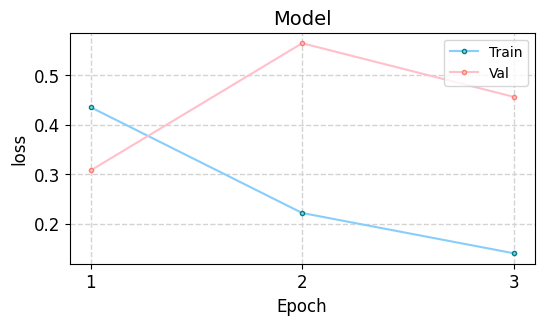

In [189]:
draw_pics(record, 'loss', img_save=False, show=True)

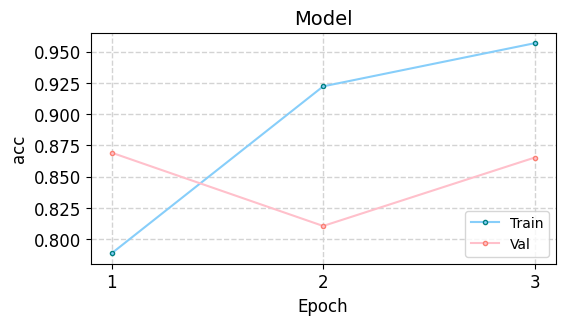

In [190]:
draw_pics(record, 'acc', img_save=False, show=True)

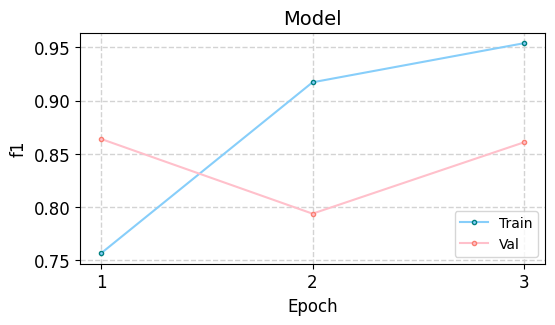

In [191]:
draw_pics(record, 'f1', img_save=False, show=True)

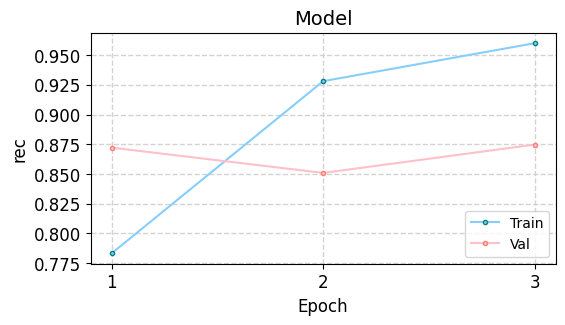

In [192]:
draw_pics(record, 'rec', img_save=False, show=True)

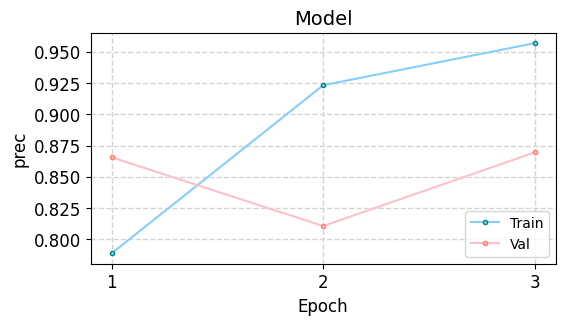

In [193]:
draw_pics(record, 'prec', img_save=False, show=True)

## 預測結果

預測單筆（跟評估的程式大同小異）




In [194]:
def Softmax(x):
  return torch.exp(x) / torch.exp(x).sum()
# label to class
def label2class(label):
  l2c = {0:'negative', 1:'positive'}
  return l2c[label]

* TODO7: 完成predict_one()

In [195]:
# predict single sentence, return each-class's probability and predicted class
def predict_one(query, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  encoded_dict = tokenizer.encode_plus(
                    query,                     
                    add_special_tokens = True, 
                    max_length = 512,           
                    padding = 'max_length',
                    return_attention_mask = True,   
                    return_tensors = 'pt',     
               )
  
  input_ids = encoded_dict['input_ids'].to(device)
  attention_mask = encoded_dict['attention_mask'].to(device)
  token_type_ids = encoded_dict['token_type_ids'].to(device)

  
  with torch.no_grad():
    logits = model(input_ids, attention_mask, token_type_ids)
    probs = Softmax(logits) 
    label_index = torch.argmax(probs[0], dim=0)
    pred = label_index.item()

  
  return probs, pred

In [196]:
# you can load model from existing result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_model = BertClassifier.from_pretrained(parameters['config'], parameters) # build an initial model
model = load_checkpoint('./bert.pt', init_model, device).to(device) # and load the weight of model from specify file

Model loaded from <== ./bert.pt


In [197]:
%%time
probs, pred = predict_one("This movie doesn't attract me", model)
print(label2class(pred))

negative
CPU times: user 61.2 ms, sys: 1 µs, total: 61.2 ms
Wall time: 152 ms


你也可以像evaluate function一樣，把它寫成dataloader的形式

In [198]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_probs, total_pred = [], []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      input_ids, attention_mask, \
      token_type_ids = [t.to(device) for t in data]

      # forward pass
      logits = model(input_ids, attention_mask, token_type_ids)
      probs = Softmax(logits) # get each class-probs
      label_index = torch.argmax(probs[0], dim=0)
      pred = label_index.item()

      total_probs.append(probs)
      total_pred.append(pred)

  return total_probs, total_pred

In [199]:
# load testing data
test_df = pd.read_csv('./test.tsv', sep = '\t').sample(500).reset_index(drop=True) 
test_dataset = CustomDataset('test', test_df, 'text', parameters)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_probs, total_pred = predict(test_loader, model)
res = test_df.copy()
# add predict class of origin file 
res['pred'] = total_pred

# save result
res.to_csv('./result.tsv', sep='\t', index=False)

In [200]:
res.head(5)

,text,label,pred
0,Eglimata (= Crimes) is a story about little cr...,1,0
1,What exactly do people expect when they watch ...,1,0
2,Paul Verhoeven has one of the strangest oeuvre...,1,1
3,"The plot for Descent, if it actually can be ca...",0,0
4,Her embalmed look was totally inappropriate fo...,0,0


In [201]:
correct = 0
for idx, pred in enumerate(res['pred']):
  if pred == res['label'][idx]:
    correct += 1
print('test accuracy = %.4f'%(correct/len(test_df)))

test accuracy = 0.8560
